In [ ]:

"""
NEAT evloving a PricePredictGenome able to predict stock prices for minimum prediction error
"""

from __future__ import print_function
import os
import neat
import visualize
import csv
import math
from decimal import *
import bigfloat
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


def normalize_data(data_array):
    data_norm = []
    minx = min(data_array)
    maxx = max(data_array)
    for data in data_array:
        data_norm.append(2*((data-minx)/(maxx-minx))-1)
    return data_norm, minx, maxx


def denormalize_value(val,minx,maxx):
    return bigfloat.BigFloat(minx+((val+1)*(maxx-minx)/2))

        
def load_data_from_csv(filename):
    data = []
    data_open = []
    data_high = []
    data_low = []
    data_close = []
    data_volume = []
    with open(filename, 'r') as File:  
        reader = csv.reader(File)
        for row in reader:
            data.append((round(float(row[1]),2),round(float(row[2]),2),round(float(row[3]),2),round(float(row[4]),2),round(float(row[5]),2)))
            data_open.append(round(float(row[1]),2))
            data_high.append(round(float(row[2]),2))
            data_low.append(round(float(row[3]),2))
            data_close.append(round(float(row[4]),2))
            data_volume.append(round(float(row[5]),2))
    return data, data_open,data_high,data_low,data_close,data_volume


# Open, High, Low, Close, Volume
def combine_arrays(arr1,arr2,arr3,arr4,arr5,):
    index = len(arr1)
    output = []
    for i in range(0,index):
        output.append((arr1[i],arr2[i],arr3[i],arr4[i],arr5[i]))
    return output


input_training_data,input_training_data_open,input_training_data_high,input_training_data_low,input_training_data_close,input_training_data_volume = load_data_from_csv('CAC40_2005_2017.csv')
input_testing_data,input_testing_data_open,input_testing_data_high,input_testing_data_low,input_testing_data_close,input_testing_data_volume = load_data_from_csv('CAC40_2017_2018.csv')


input_training_data_open_norm, input_training_data_open_minx, input_training_data_open_maxx = normalize_data(input_training_data_open)
input_training_data_high_norm, input_training_data_high_minx, input_training_data_high_maxx = normalize_data(input_training_data_high)
input_training_data_low_norm, input_training_data_low_minx, input_training_data_low_maxx = normalize_data(input_training_data_low)
input_training_data_close_norm, input_training_data_close_minx, input_training_data_close_maxx = normalize_data(input_training_data_close)
input_training_data_volume_norm, input_training_data_volume_minx, input_training_data_volume_maxx = normalize_data(input_training_data_volume)


input_testing_data_open_norm, input_testing_data_open_minx, input_testing_data_open_maxx = normalize_data(input_testing_data_open)
input_testing_data_high_norm, input_testing_data_high_minx, input_testing_data_high_maxx = normalize_data(input_testing_data_high)
input_testing_data_low_norm, input_testing_data_low_minx, input_testing_data_low_maxx = normalize_data(input_testing_data_low)
input_testing_data_close_norm, input_testing_data_close_minx, input_testing_data_close_maxx = normalize_data(input_testing_data_close)
input_testing_data_volume_norm, input_testing_data_volume_minx, input_testing_data_volume_maxx = normalize_data(input_testing_data_volume)


    
input_training_data_norm = combine_arrays(input_training_data_open_norm,
                                          input_training_data_high_norm,
                                          input_training_data_low_norm,
                                          input_training_data_close_norm,
                                          input_training_data_volume_norm)

input_testing_data_norm = combine_arrays(input_testing_data_open_norm,
                                          input_testing_data_high_norm,
                                          input_testing_data_low_norm,
                                          input_testing_data_close_norm,
                                          input_testing_data_volume_norm)

size = len(input_training_data_norm)
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.nn.RecurrentNetwork.create(genome, config)
        errors = []
        for i, input_data in enumerate(input_training_data_norm):
            if (i < size-1):
                output = net.activate(input_data)[0]
                output_denorm = denormalize_value(output,input_training_data_open_minx,input_training_data_open_maxx)
                errors.append(bigfloat.BigFloat((output_denorm - input_training_data_open[i+1])**2))
        
        error_sum = 0
        for error in errors:
            error_sum += error
        
        genome.fitness = float(round(-math.sqrt(error_sum/len(errors)),5))
                


                
#EXECUSTION            
local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-pricepredictgenome')
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(5))

# Run for up to X generations.
winner = p.run(eval_genomes, 2000)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.RecurrentNetwork.create(winner, config)
#testing best genome
capital = 100000.0
shares = 0

size = len(input_testing_data_norm)
for i, input_data in enumerate(input_testing_data_norm):
    if (i < size-1):
        output = winner_net.activate(input_data)[0]
        output_denorm = denormalize_value(output,input_testing_data_open_minx,input_testing_data_open_maxx)
        if(output_denorm > input_testing_data_open[i+1] and capital > input_testing_data_open[i+1]):
            shares = shares+1
            capital = capital - input_testing_data_open[i+1] #Buy on market open
        elif (shares > 0):
            shares = shares-1
            capital = capital + input_testing_data_open[i+1] #Sell on market open
                

print('Money: {!r}, Shares: {!r}\n'.format(capital,shares))

node_names = {-1:'Open', -2: 'High',-3: 'Low',-4: 'Close',-5: 'Volume', 0:'Decide'}
visualize.draw_net(config, winner, True, node_names=node_names)
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)




 ****** Running generation 0 ****** 

Population's average fitness: -1829.60650 stdev: 354.59697
Best fitness: -737.33707 - size: (3, 20) - species 1 - id 222
Average adjusted fitness: 0.370
Mean genetic distance 2.902, standard deviation 0.398
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    35   -737.3    0.374     0
     2    0    25   -843.8    0.351     0
     3    0   240  -1295.4    0.384     0
Total extinctions: 0
Generation time: 332.732 sec
Saving checkpoint to neat-checkpoint-0

 ****** Running generation 1 ****** 

Population's average fitness: -1620.80509 stdev: 349.04923
Best fitness: -737.27662 - size: (3, 20) - species 3 - id 376
Average adjusted fitness: 0.463
Mean genetic distance 2.536, standard deviation 0.547
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   281   -849.2    0.449     1
   

Population's average fitness: -989.24947 stdev: 461.63386
Best fitness: -110.27929 - size: (3, 10) - species 4 - id 1777
Average adjusted fitness: 0.524
Mean genetic distance 2.348, standard deviation 0.535
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13    36   -190.2    0.383     0
     2   13   200   -249.1    0.505     6
     3   13    57   -549.5    0.625     7
     4    8     8   -110.3    0.584     1
Total extinctions: 0
Generation time: 340.174 sec (332.524 average)
Saving checkpoint to neat-checkpoint-13

 ****** Running generation 14 ****** 

Population's average fitness: -1016.21005 stdev: 516.69194
Best fitness: -110.27929 - size: (3, 10) - species 3 - id 1777
Average adjusted fitness: 0.798
Mean genetic distance 2.311, standard deviation 0.548
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14    44   -

Population's average fitness: -1048.50078 stdev: 609.78585
Best fitness: -110.27929 - size: (3, 10) - species 3 - id 1777
Average adjusted fitness: 0.871
Mean genetic distance 2.521, standard deviation 0.495
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   26   119   -302.2    0.887    13
     2   26    52   -393.7    0.862     8
     3   26    73   -110.3    0.835    20
     4   21    56   -601.5    0.900    14
Total extinctions: 0
Generation time: 364.789 sec (337.307 average)
Saving checkpoint to neat-checkpoint-26

 ****** Running generation 27 ****** 

Population's average fitness: -1118.26790 stdev: 803.22083
Best fitness: -110.27929 - size: (3, 10) - species 3 - id 1777
Average adjusted fitness: 0.854
Mean genetic distance 2.544, standard deviation 0.506
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   27    99   


 ****** Running generation 39 ****** 

Population's average fitness: -1117.28545 stdev: 778.66879
Best fitness: -46.28896 - size: (6, 8) - species 2 - id 10438
Average adjusted fitness: 0.744
Mean genetic distance 3.000, standard deviation 0.548
Population of 300 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   39    92    -46.3    0.789     4
     3   39    34   -128.2    0.800     6
     5    5    60    -79.7    0.800     1
     6    3    41   -134.7    0.756     1
     7    2     7   -606.2    0.717     0
     8    1    29   -317.6    0.730     0
     9    1    37   -130.4    0.617     0
Total extinctions: 0
Generation time: 337.722 sec (336.667 average)
Saving checkpoint to neat-checkpoint-39

 ****** Running generation 40 ****** 

Population's average fitness: -1122.91686 stdev: 820.74094
Best fitness: -35.76240 - size: (6, 7) - species 2 - id 12005
Average adjusted fitness: 0.740
Mean genetic distance 2.878, stand

Generation time: 340.382 sec (336.559 average)
Saving checkpoint to neat-checkpoint-49

 ****** Running generation 50 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -34.56901 - size: (6, 6) - species 2 - id 13139
Average adjusted fitness: nan
Mean genetic distance 3.072, standard deviation 0.624
Population of 298 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   50    46    -34.6      nan     6
     3   50    40    -41.6      nan     0
     5   16    44    -79.7      nan    12
     6   14    44    -51.0      nan     1
     7   13    40   -570.5      nan     5
     8   12    40    -57.4      nan     8
     9   12    44    -78.5      nan     0
Total extinctions: 0
Generation time: 337.543 sec (337.302 average)
Saving checkpoint to neat-checkpoint-50

 ****** Running generation 51 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -34.56901 - size: (6, 6) - species 2 - id 13139
Average


 ****** Running generation 61 ****** 

Population's average fitness: -979.93046 stdev: 695.40765
Best fitness: -34.56901 - size: (6, 6) - species 2 - id 13139
Average adjusted fitness: 0.781
Mean genetic distance 2.890, standard deviation 0.681
Population of 301 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   61    42    -34.6    0.771    17
     3   61    45    -37.1    0.811     8
     5   27    43    -61.3    0.810     5
     6   25    45    -35.8    0.759     2
     7   24    41   -327.3    0.746    16
     8   23    43    -57.4    0.815    19
     9   23    42    -78.5    0.757    11
Total extinctions: 0
Generation time: 360.091 sec (364.042 average)
Saving checkpoint to neat-checkpoint-61

 ****** Running generation 62 ****** 

Population's average fitness: -985.91995 stdev: 706.90153
Best fitness: -34.56901 - size: (6, 6) - species 2 - id 13139

Species 8 with 43 members is stagnated: removing it
Average adjuste


 ****** Running generation 72 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -34.56901 - size: (6, 6) - species 2 - id 13139
Average adjusted fitness: nan
Mean genetic distance 2.789, standard deviation 0.636
Population of 300 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   72    57    -34.6      nan    28
     3   72    52    -37.1      nan    19
     5   38    52    -61.3      nan    16
     6   36    42    -35.8      nan    13
     7   35    47   -131.1      nan     0
     9   34    50    -59.3      nan     6
Total extinctions: 0
Generation time: 333.877 sec (342.590 average)
Saving checkpoint to neat-checkpoint-72

 ****** Running generation 73 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -34.56901 - size: (6, 6) - species 2 - id 13139

Species 3 with 52 members is stagnated: removing it
Average adjusted fitness: nan
Mean genetic distance 2.696, standard deviation 0.646


 ****** Running generation 85 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -33.08331 - size: (6, 7) - species 6 - id 23726
Average adjusted fitness: nan
Mean genetic distance 2.454, standard deviation 0.620
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   85    78    -34.6      nan    41
     6   49    68    -33.1      nan     4
     7   48    77    -62.7      nan     6
     9   47    76    -59.3      nan    19
Total extinctions: 0
Generation time: 297.670 sec (301.895 average)

 ****** Running generation 86 ****** 

Population's average fitness: -981.33354 stdev: 696.91666
Best fitness: -33.08331 - size: (6, 7) - species 6 - id 23726

Species 9 with 76 members is stagnated: removing it
Average adjusted fitness: 0.771
Mean genetic distance 2.163, standard deviation 0.522
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  ======= 


 ****** Running generation 99 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -33.08331 - size: (6, 7) - species 6 - id 23726
Average adjusted fitness: nan
Mean genetic distance 2.212, standard deviation 0.510
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2   99   128    -34.6      nan    55
     6   63    66    -33.1      nan    18
     7   62   106    -59.1      nan     8
Total extinctions: 0
Generation time: 330.749 sec (335.021 average)
Saving checkpoint to neat-checkpoint-99

 ****** Running generation 100 ****** 

Population's average fitness: -3635819476946818361183961088.00000 stdev: 62869195934216046815022678016.00000
Best fitness: -33.08331 - size: (6, 7) - species 6 - id 23726
Average adjusted fitness: 0.997
Mean genetic distance 2.320, standard deviation 0.455
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ==

Population's average fitness: -985.96356 stdev: 722.90746
Best fitness: -33.02349 - size: (7, 10) - species 2 - id 32993
Average adjusted fitness: 0.752
Mean genetic distance 2.123, standard deviation 0.403
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2  113    44    -33.0    0.762     0
     6   77   256    -33.1    0.742    32
Total extinctions: 0
Generation time: 319.633 sec (330.330 average)
Saving checkpoint to neat-checkpoint-113

 ****** Running generation 114 ****** 

Population's average fitness: -981.34927 stdev: 758.02301
Best fitness: -33.02349 - size: (7, 10) - species 6 - id 32993
Average adjusted fitness: 0.784
Mean genetic distance 2.265, standard deviation 0.377
Population of 300 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2  114    33   -129.4    0.787     1
     6   78   267    -33.0    0.782     0
Total extinctions: 0

Population's average fitness: -inf stdev: nan
Best fitness: -33.02349 - size: (7, 10) - species 6 - id 32993
Average adjusted fitness: nan
Mean genetic distance 2.802, standard deviation 0.596
Population of 301 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2  127    76    -46.5      nan    14
     6   91   129    -33.0      nan    13
    10    8    10   -580.9      nan     4
    11    4    86    -71.4      nan     0
Total extinctions: 0
Generation time: 328.890 sec (326.937 average)
Saving checkpoint to neat-checkpoint-127

 ****** Running generation 128 ****** 

Population's average fitness: -992.50133 stdev: 647.87747
Best fitness: -33.02349 - size: (7, 10) - species 6 - id 32993
Average adjusted fitness: 0.731
Mean genetic distance 2.792, standard deviation 0.672
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     2  128    76    -46.5    0.74


 ****** Running generation 140 ****** 

Population's average fitness: -942.82352 stdev: 750.84153
Best fitness: -33.02349 - size: (7, 10) - species 6 - id 32993
Average adjusted fitness: 0.811
Mean genetic distance 2.655, standard deviation 0.629
Population of 299 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     6  104    97    -33.0    0.813    26
    10   21    99    -48.5    0.784     3
    11   17   103    -43.7    0.837    12
Total extinctions: 0
Generation time: 333.485 sec (360.412 average)
Saving checkpoint to neat-checkpoint-140

 ****** Running generation 141 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -33.02349 - size: (7, 10) - species 6 - id 32993
Average adjusted fitness: nan
Mean genetic distance 2.693, standard deviation 0.586
Population of 300 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     6  105   105    -33.0      nan


 ****** Running generation 153 ****** 

Population's average fitness: -1120.55047 stdev: 929.09096
Best fitness: -33.02349 - size: (7, 10) - species 10 - id 32993
Average adjusted fitness: 0.815
Mean genetic distance 2.806, standard deviation 0.619
Population of 299 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   34    74    -33.0    0.792     6
    11   30    87    -38.5    0.842     4
    12    6    56    -77.6    0.818     3
    13    4    82    -65.5    0.808     1
Total extinctions: 0
Generation time: 320.791 sec (323.392 average)
Saving checkpoint to neat-checkpoint-153

 ****** Running generation 154 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -33.02349 - size: (7, 10) - species 10 - id 32993
Average adjusted fitness: nan
Mean genetic distance 2.792, standard deviation 0.621
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  ====


 ****** Running generation 166 ****** 

Population's average fitness: -960.39008 stdev: 748.87924
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.821
Mean genetic distance 3.052, standard deviation 0.516
Population of 301 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   47    48    -32.9    0.785     4
    11   43    74    -38.5    0.846    17
    12   19    86    -35.7    0.831     1
    13   17    58    -78.2    0.808     5
    14    5    28    -45.7    0.835     3
    15    0     7       --       --     0
Total extinctions: 0
Generation time: 328.105 sec (326.214 average)
Saving checkpoint to neat-checkpoint-166

 ****** Running generation 167 ****** 

Population's average fitness: -936.04020 stdev: 696.84068
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.728
Mean genetic distance 3.084, standard deviation 0.571
Population of 299 m

Population's average fitness: -1000.90531 stdev: 916.92161
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.905
Mean genetic distance 2.914, standard deviation 0.587
Population of 299 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   59    53    -32.9    0.882    16
    12   31    59    -35.7    0.908    13
    13   29    61    -41.0    0.915     0
    14   17    69    -35.2    0.912     1
    15   12    57    -35.8    0.909     2
Total extinctions: 0
Generation time: 325.856 sec (323.222 average)
Saving checkpoint to neat-checkpoint-178

 ****** Running generation 179 ****** 

Population's average fitness: -940.37152 stdev: 739.93129
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.777
Mean genetic distance 2.907, standard deviation 0.542
Population of 301 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  


 ****** Running generation 190 ****** 

Population's average fitness: -1004.46610 stdev: 849.75106
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.855
Mean genetic distance 2.859, standard deviation 0.584
Population of 300 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   71    55    -32.9    0.810    28
    13   41    68    -33.6    0.861    10
    14   29    66    -35.2    0.871    13
    15   24    44   -102.6    0.878    14
    16    4    63   -109.5    0.856     2
    17    0     4       --       --     0
Total extinctions: 0
Generation time: 334.065 sec (327.905 average)
Saving checkpoint to neat-checkpoint-190

 ****** Running generation 191 ****** 

Population's average fitness: -986.62284 stdev: 733.28437
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.786
Mean genetic distance 2.906, standard deviation 0.554
Population of 302 


 ****** Running generation 201 ****** 

Population's average fitness: -1028.26892 stdev: 700.70727
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.796
Mean genetic distance 2.923, standard deviation 0.608
Population of 301 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   82    62    -32.9    0.797    39
    14   40    41    -33.1    0.805    10
    15   35    31   -114.9    0.813     8
    16   15    56    -72.0    0.776     6
    17   11    42   -212.7    0.781     5
    18    1    69   -985.3    0.803     0
Total extinctions: 0
Generation time: 325.919 sec (326.482 average)
Saving checkpoint to neat-checkpoint-201

 ****** Running generation 202 ****** 

Population's average fitness: -1111.26815 stdev: 1663.99985
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.958
Mean genetic distance 2.912, standard deviation 0.557
Population of 30


 ****** Running generation 213 ****** 

Population's average fitness: -993.03674 stdev: 844.69296
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575

Species 15 with 25 members is stagnated: removing it
Average adjusted fitness: 0.839
Mean genetic distance 3.033, standard deviation 0.690
Population of 300 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   94    86    -32.9    0.837    51
    16   27    12    -60.7    0.819    18
    17   23    63    -47.6    0.818    17
    18   13    56    -33.0    0.847    11
    19    1    83   -109.7    0.872     0
Total extinctions: 0
Generation time: 325.552 sec (326.088 average)
Saving checkpoint to neat-checkpoint-213

 ****** Running generation 214 ****** 

Population's average fitness: -296957046723860098942953950512537347745155103394469593696403695389818793838559043238059212101648384.00000 stdev: 5134867358762857657325220637189675987031318684144028468680500897525003


 ****** Running generation 226 ****** 

Population's average fitness: -1192.54879 stdev: 3399.94856
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: 0.977
Mean genetic distance 3.031, standard deviation 0.557
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10  107   102    -32.9    0.984    64
    18   26    63    -33.0    0.964    24
    19   14    76    -60.7    0.984    11
    20    1    59   -288.0    0.976     0
Total extinctions: 0
Generation time: 330.524 sec (328.074 average)
Saving checkpoint to neat-checkpoint-226

 ****** Running generation 227 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: nan
Mean genetic distance 3.070, standard deviation 0.534
Population of 300 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =====


 ****** Running generation 239 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: nan
Mean genetic distance 2.964, standard deviation 0.639
Population of 299 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10  120    95    -32.9      nan    77
    18   39    45    -33.0      nan    37
    19   27    39    -54.6      nan     6
    20   14    56    -61.9      nan    10
    21    5    64    -47.7      nan     3
Total extinctions: 0
Generation time: 330.662 sec (329.123 average)
Saving checkpoint to neat-checkpoint-239

 ****** Running generation 240 ****** 

Population's average fitness: -inf stdev: nan
Best fitness: -32.90431 - size: (7, 9) - species 10 - id 47575
Average adjusted fitness: nan
Mean genetic distance 2.972, standard deviation 0.654
Population of 301 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ==== 


 ****** Running generation 0 ****** 

Population's average fitness: 2.24579 stdev: 0.36935
Best fitness: 2.99798 - size: (1, 2) - species 1 - id 66
Average adjusted fitness: 0.568
Mean genetic distance 1.113, standard deviation 0.421
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   200      3.0    0.568     0
Total extinctions: 0
Generation time: 0.020 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.32507 stdev: 0.32291
Best fitness: 2.99964 - size: (1, 2) - species 1 - id 385
Average adjusted fitness: 0.592
Mean genetic distance 1.268, standard deviation 0.489
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   200      3.0    0.592     0
Total extinctions: 0
Generation time: 0.023 sec (0.022 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.27506 stdev: 0

Mean genetic distance 1.706, standard deviation 0.357
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    87      3.0    0.181     4
     2   10   113      3.3    0.266     1
Total extinctions: 0
Generation time: 0.039 sec (0.036 average)

 ****** Running generation 19 ****** 

Population's average fitness: 2.32116 stdev: 0.32110
Best fitness: 3.32932 - size: (2, 3) - species 2 - id 3542
Average adjusted fitness: 0.239
Mean genetic distance 1.839, standard deviation 0.170
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19   177      3.2    0.223     5
     2   11    23      3.3    0.256     2
Total extinctions: 0
Generation time: 0.041 sec (0.037 average)
Saving checkpoint to neat-checkpoint-19

 ****** Running generation 20 ****** 

Population's average fitness: 2.29275 stdev: 0.34378
Best fitness: 3.32932 - size: (

Mean genetic distance 1.876, standard deviation 0.419
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37    55      3.3    0.555    10
     2   29   145      3.1    0.598    15
Total extinctions: 0
Generation time: 0.042 sec (0.047 average)

 ****** Running generation 38 ****** 

Population's average fitness: 2.44037 stdev: 0.45111
Best fitness: 3.33263 - size: (2, 3) - species 1 - id 5440
Average adjusted fitness: 0.600
Mean genetic distance 1.849, standard deviation 0.424
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   38    62      3.3    0.588    11
     2   30   138      3.1    0.611    16
Total extinctions: 0
Generation time: 0.041 sec (0.045 average)

 ****** Running generation 39 ****** 

Population's average fitness: 2.44794 stdev: 0.46016
Best fitness: 3.33263 - size: (2, 3) - species 1 - id 5440
Average adju

Population's average fitness: 2.44951 stdev: 0.46905
Best fitness: 3.33270 - size: (2, 3) - species 1 - id 10798
Average adjusted fitness: 0.564
Mean genetic distance 1.790, standard deviation 0.430
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   55    64      3.3    0.581     1
     2   47   136      3.2    0.546    33
Total extinctions: 0
Generation time: 0.045 sec (0.047 average)

 ****** Running generation 56 ****** 

Population's average fitness: 2.41132 stdev: 0.46097
Best fitness: 3.33270 - size: (2, 3) - species 1 - id 10798
Average adjusted fitness: 0.511
Mean genetic distance 1.777, standard deviation 0.441
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   56    59      3.3    0.502     2
     2   48   141      3.2    0.520    34
Total extinctions: 0
Generation time: 0.050 sec (0.044 average)

 ****** Running g

Mean genetic distance 1.921, standard deviation 0.363
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   73    52      3.5    0.582     3
     2   65   148      3.3    0.528    51
Total extinctions: 0
Generation time: 0.064 sec (0.056 average)

 ****** Running generation 74 ****** 

Population's average fitness: 2.50422 stdev: 0.46686
Best fitness: 3.48745 - size: (2, 4) - species 2 - id 13919
Average adjusted fitness: 0.391
Mean genetic distance 1.959, standard deviation 0.361
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   74    58      3.5    0.356     4
     2   66   142      3.5    0.425     0
Total extinctions: 0
Generation time: 0.058 sec (0.057 average)
Saving checkpoint to neat-checkpoint-74

 ****** Running generation 75 ****** 

Population's average fitness: 2.52777 stdev: 0.47147
Best fitness: 3.48745 - size: 

Mean genetic distance 1.981, standard deviation 0.367
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   91    51      3.5    0.490    21
     2   83   149      3.0    0.542    17
Total extinctions: 0
Generation time: 0.061 sec (0.064 average)

 ****** Running generation 92 ****** 

Population's average fitness: 2.50125 stdev: 0.46483
Best fitness: 3.48745 - size: (2, 4) - species 1 - id 13919
Average adjusted fitness: 0.317
Mean genetic distance 1.990, standard deviation 0.358
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   92    42      3.5    0.267    22
     2   84   158      3.0    0.367    18
Total extinctions: 0
Generation time: 0.087 sec (0.067 average)

 ****** Running generation 93 ****** 

Population's average fitness: 2.55924 stdev: 0.47113
Best fitness: 3.48745 - size: (2, 4) - species 1 - id 13919
Average ad

Mean genetic distance 2.330, standard deviation 0.563
Population of 200 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  109   104      3.7    0.318     2
     3    1    93      3.3    0.524     0
     4    0     2       --       --     0
     5    0     1       --       --     0
Total extinctions: 0
Generation time: 0.062 sec (0.079 average)
Saving checkpoint to neat-checkpoint-109

 ****** Running generation 110 ****** 

Population's average fitness: 2.46275 stdev: 0.46224
Best fitness: 3.65648 - size: (3, 6) - species 1 - id 21187
Average adjusted fitness: 0.224
Mean genetic distance 2.506, standard deviation 0.577
Population of 200 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  110    78      3.7    0.255     3
     3    2    89      3.3    0.434     1
     4    1    21      2.2    0.127     0
     5    1    12      2.0    0.082     0
Total extinctions

Mean genetic distance 2.565, standard deviation 0.617
Population of 200 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  122    38      3.8    0.536     6
     3   14    29      3.3    0.537    13
     4   13    40      3.0    0.503     0
     5   13    44      3.0    0.440     1
     6    8    49      3.0    0.539     7
Total extinctions: 0
Generation time: 0.058 sec (0.060 average)

 ****** Running generation 123 ****** 

Population's average fitness: 2.47889 stdev: 0.45365
Best fitness: 3.75165 - size: (3, 6) - species 1 - id 22906
Average adjusted fitness: 0.438
Mean genetic distance 2.571, standard deviation 0.629
Population of 199 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  123    34      3.8    0.433     7
     3   15    31      3.3    0.399    14
     4   14    37      3.0    0.431     0
     5   14    46      3.0    0.427     0
     6    9    5

Mean genetic distance 2.549, standard deviation 0.569
Population of 200 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  135    48      4.0    0.448     0
     3   27    41      3.3    0.453     0
     4   26    34      3.0    0.374    10
     5   26    36      3.3    0.440     7
     6   21    41      3.3    0.482     0
Total extinctions: 0
Generation time: 0.074 sec (0.067 average)

 ****** Running generation 136 ****** 

Population's average fitness: 2.44331 stdev: 0.48641
Best fitness: 3.98412 - size: (2, 5) - species 1 - id 26493
Average adjusted fitness: 0.449
Mean genetic distance 2.467, standard deviation 0.530
Population of 201 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  136    49      4.0    0.441     1
     3   28    92      3.3    0.427     1
     4   27    37      3.0    0.405    11
     5   27    10      3.3    0.493     8
     6   22    1

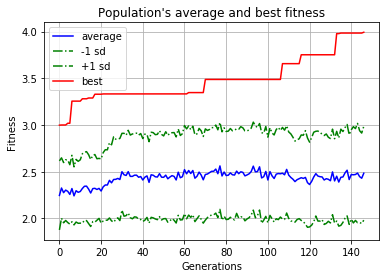

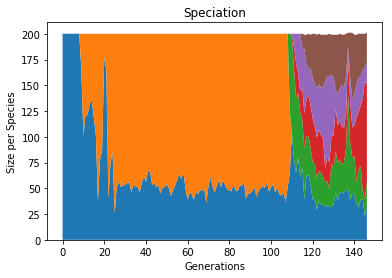

Mean genetic distance 1.564, standard deviation 0.565
Mean genetic distance 1.775, standard deviation 0.508
Mean genetic distance 1.890, standard deviation 0.398
Mean genetic distance 1.958, standard deviation 0.406
Mean genetic distance 1.972, standard deviation 0.315
Mean genetic distance 1.854, standard deviation 0.234
Mean genetic distance 1.751, standard deviation 0.262
Mean genetic distance 1.711, standard deviation 0.354
Mean genetic distance 1.699, standard deviation 0.333
Mean genetic distance 1.739, standard deviation 0.323


In [9]:
"""
Testing TraderGenome
"""

from __future__ import print_function
import os
import neat
import visualize
import csv
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

local_dir = os.getcwd()
config_path = os.path.join(local_dir, 'config-tradergenome')
# Load configuration.
config = neat.Config(TraderGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_path)

input_training_data = load_data_from_csv('CAC40_2005_2017.csv')
input_testing_data = load_data_from_csv('CAC40_2017_2018.csv')
input_training_data += input_testing_data
input_testing_data=input_training_data

p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-999')
winner = p.run(eval_genomes, 3)

winner_net = neat.nn.RecurrentNetwork.create(winner, config)



#testing best genome
capital = 100000.0
shares = 0
size = len(input_testing_data)
buy_count = 0
sell_count = 0
hodl_count = 0
for i, input_data in enumerate(input_testing_data):
    if (i < size-1):
            output = winner_net.activate(input_data)
            decision = decide(output[0]) #-1: sell | 0: HODL | 1: buy
            if (decision == -1 and shares > 0):
                shares = shares-1
                capital = capital + input_testing_data[i+1][1] #Sell on market open
                sell_count = sell_count+1

            elif (decision == 1 and capital > input_testing_data[i+1][1]):
                shares = shares+1
                capital = capital - input_testing_data[i+1][1] #Buy on market open
                buy_count = buy_count+1
            else: 
                hodl_count = hodl_count+1
print('Money: {!r}, Shares: {!r}\n'.format(capital,shares))
print('buy_count: {!r}, sell_count: {!r}, hodl_count: {!r}\n'.format(buy_count,sell_count,hodl_count))      

print('\nBest genome:\n{!s}'.format(winner))
